# Regression Tree From Scratch Using Python

In this story, I dive into the topic of Regression Tree and its basic mathematical background. I will try to explain it as simple as possible and create a working model using python from scratch. 

I will be using recursion to create tree nodes, so if that is something you are not familiar with, I recommend looking some examples and explanations online (though I still will be explaining its logic briefly).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Creating Data

Beginning with creating a numerical data, the data will have an independent variable (x) and a dependent one (y). Using numpy, I will add a gaussian noise to dependent values, which can be expressed mathematically as 

$$ y = f(x) + \epsilon $$

where $\epsilon$ is the noise.

Using numpy for creating a data, we can calculate dependent variable and add noise in one step as below.

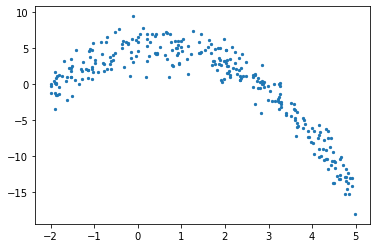

In [2]:
def f(x):
    mu, sigma = 0, 1.5
    return -x**2 + x + 5 + np.random.normal(mu, sigma, 1)

num_points = 300
np.random.seed(1)
    
x = np.random.uniform(-2, 5, num_points)
y = np.array( [f(i) for i in x] )

plt.scatter(x, y, s = 5)

## Regression Tree

In a regression tree, we predict numerical data by creating a tree of multiple nodes where every training point ends up in one node. All input values of X that reaches a node m, can be represented with a subset of X.

$$ 
b_m(x) = 
\begin{cases} 
    1 \mbox{,} & \mbox{if } x \in X_m \\
    0 \mbox{,} & \mbox{otherwise } 
\end{cases} \ 
$$

First we iterate through the sorted training data by picking 2 consecutive points at each step, and calculate their mean. The mean we calculate is the threshold value to split the data into two. Let us consider one example as below.

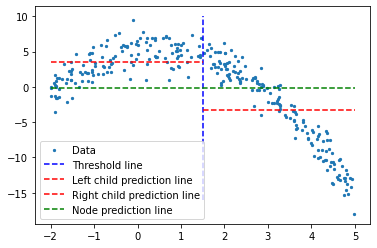

In [5]:
threshold = 1.5

low = np.take(y, np.where(x < threshold))
high = np.take(y, np.where(x > threshold))

plt.scatter(x, y, s = 5, label = 'Data')
plt.plot([threshold]*2, [-16, 10], 'b--', label = 'Threshold line')
plt.plot([-2, threshold], [low.mean()]*2, 'r--', label = 'Left child prediction line')
plt.plot([threshold, 5], [high.mean()]*2, 'r--', label = 'Right child prediction line')
plt.plot([-2, 5], [y.mean()]*2, 'g--', label = 'Node prediction line')
plt.legend()

While it is clear that none of these mean values represent our data well, it shows the difference; main node prediction (green line) gets the mean value of all data and for any value, it would predict a single value, but we divide it into 2 children nodes and those 2 children have their own predictions (red lines) which represents their corresponding data a little bit better, compared to the green line. We will be constantly dividing the data into 2 - creating 2 childrens from every node until we hit a given stop value, which is the least amount of data a node can have. 
Remember: If we were to continue dividing up till we reach a single value, it would create an overfitting scenario where for each training data, its prediction would be itself. To get the threshold value which best represents the data, we use sum of squared residuals. It can be defined mathematically as

$$ SSR = \sum_{j=1}^J\sum_i(y_i-\bar{y_{mj}})^2 \cdot b_{mj}(x_i) $$

Let us see in action, how this step works.

$$ \mbox{Iterate through data} \to \mbox{Calculate SSR for every threshold} \to \mbox{Find threshold with minimum SSR} $$

$$ \to \mbox{Calculate means for that threshold} \to \mbox{Create node} \to \mbox{Repeat for children node until limit is reached} $$


## Sum of Squared Residuals

For every data point, we need to calculate sum of squared distances from the data point to the mean of that interval.

In [6]:
def SSR(r, y): 
    return np.sum( (r - y)**2 )

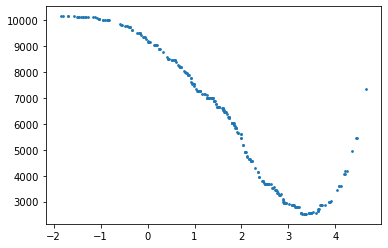

In [7]:
SSRs, thresholds = [], []
for i in range(len(x) - 1):
    threshold = x[i:i+2].mean()
    
    low = np.take(y, np.where(x < threshold))
    high = np.take(y, np.where(x > threshold))
    
    guess_low = low.mean()
    guess_high = high.mean()
    
    SSRs.append(SSR(low, guess_low) + SSR(high, guess_high))
    thresholds.append(threshold)
    
plt.scatter(thresholds, SSRs, s = 3)
plt.show()

In [8]:
print('Minimum residual is: {:.2f}'.format(min(SSRs)))
print('Corresponding threshold value is: {:.4f}'.format(thresholds[SSRs.index(min(SSRs))]))

Minimum residual is: 2527.33
Corresponding threshold value is: 3.3239


All that is left to do is to repeat this step while creating child nodes. For every child node, we will be 

In [9]:
df = pd.DataFrame(zip(x, y.squeeze()), columns = ['x', 'y'])

In [11]:
def find_threshold(df, plot = False):
    SSRs, thresholds = [], []
    for i in range(len(df) - 1):
        threshold = df.x[i:i+2].mean()

        low = df[(df.x <= threshold)]
        high = df[(df.x > threshold)]

        guess_low = low.y.mean()
        guess_high = high.y.mean()

        SSRs.append(SSR(low.y.to_numpy(), guess_low) + SSR(high.y.to_numpy(), guess_high))
        thresholds.append(threshold)
    
    if plot:
        plt.scatter(thresholds, SSRs, s = 3)
        plt.show()
        
    return thresholds[SSRs.index(min(SSRs))]

## Creating children nodes

Now that we have split our data into two, we can find seperate thresholds for both the low values and high values. Though note that we need a stopping condition; since with every node, the points in the dataset which belongs to a node gets smaller, we define a minimum number of data points for every node. If we were not to do this, every node would predict using only 1 training value, resulting in an overfitting.

We can create our nodes recursively. For that, we define a class named TreeNode which will store every value a node should. After that, we create the root first, while calculating its threshold and prediction values. Then we recursively create its children nodes, where every children node class is stored as an attribute of its parent class, either named left or right. 

In create_nodes method, we start by splitting the given dataframe into two parts; low and high, using that node's threshold. Then we check if there is enough data points to create left and right nodes in seperate if conditions, by using their corresponding dataframes. If there are (for either one) enough data points, we calculate threshold value for its dataframe, create a child node with it and call create_nodes method again with this new node as our tree.

In [15]:
class TreeNode():
    def __init__(self, threshold, pred):
        self.threshold = threshold
        self.pred = pred
        self.left = None
        self.right = None

def create_nodes(tree, df, stop):
    low = df[df.x <= tree.threshold]
    high = df[df.x > tree.threshold]
    
    if len(low) > stop:
        threshold = find_threshold(low)
        tree.left = TreeNode(threshold, low.y.mean())
        create_nodes(tree.left, low, stop)
        
    if len(high) > stop:
        threshold = find_threshold(high)
        tree.right = TreeNode(threshold, high.y.mean())
        create_nodes(tree.right, high, stop)
        
threshold = find_threshold(df)
tree = TreeNode(threshold, df.y.mean())

create_nodes(tree, df, 5)

Note that this method makes its changes on the first tree provided to it, so it does not require to return anything.
Also note that while this is not usually how a recursive function is written (no return), we do not require a return since when no if statement is activated, method will return itself.

In [18]:
def predict(x):
    curr_node = tree
    result = None
    while True:
        if x <= curr_node.threshold:
            if curr_node.left: curr_node = curr_node.left
            else: 
                break
        elif x > curr_node.threshold:
            if curr_node.right: curr_node = curr_node.right
            else: 
                break
                
    return curr_node.pred
    
predict(3)

-1.3165119892538402

In [19]:
def RSE(y, g): 
    return sum(np.square(y - g)) / sum(np.square(y - 1 / len(y)*sum(y)))

preds = np.array( [predict(i) for i in df.x] )
RSE(df.y, preds)

0.05559550063812675

In [74]:
def RSE(y, g): 
    return sum(np.square(y - g)) / sum(np.square(y - 1 / len(y)*sum(y)))

x_val = np.random.uniform(-2, 5, 50)
y_val = np.array( [f(i) for i in x_val] ).squeeze()

tr_preds = np.array( [predict(i) for i in df.x] )
val_preds = np.array( [predict(i) for i in x_val] )
print('Training error: {:.4f}'.format(RSE(df.y, tr_preds)))
print('Validation error: {:.4f}'.format(RSE(y_val, val_preds)))

Training error: 0.0358
Validation error: 0.0595


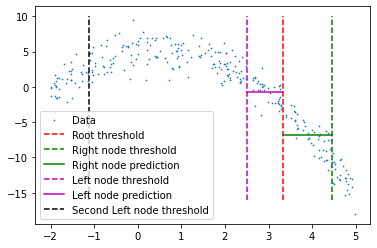

In [23]:
plt.scatter(x, y, s = 0.5, label = 'Data')
plt.plot([tree.threshold]*2, [-16, 10], 'r--', 
         label = 'Root threshold')
plt.plot([tree.right.threshold]*2, [-16, 10], 'g--', 
         label = 'Right node threshold')
plt.plot([tree.threshold, tree.right.threshold], 
         [tree.right.left.pred]*2,
         'g', label = 'Right node prediction')
plt.plot([tree.left.threshold]*2, [-16, 10], 'm--', 
         label = 'Left node threshold')
plt.plot([tree.left.threshold, tree.threshold], 
         [tree.left.right.pred]*2,
         'm', label = 'Left node prediction')
plt.plot([tree.left.left.threshold]*2, [-16, 10], 'k--',
         label = 'Second Left node threshold')
plt.legend()

We see 2 predictions here:
First left node's predictions for high values (higher than its threshold)
First right node's predictions for low values (lower than its threshold)

I have cut the prediction lines' widths manually, which is because if a given x value reaches either of those nodes, it will be represented by the mean  of all x values that belong to that node, which also means that no other x value participates in the prediction of that node (hope that makes sense).

In [59]:
tree.left.right.left.left

## Appendix

$$ 
y = 
\begin{cases} 
    1 + \epsilon \mbox{,} & \mbox{if } x < 3 \\ 
    9 + \epsilon \mbox{,} & \mbox{if } 3 < x < 6 \\
    5 + \epsilon \mbox{,} & \mbox{if } 6 < x 
\end{cases} \ 
$$

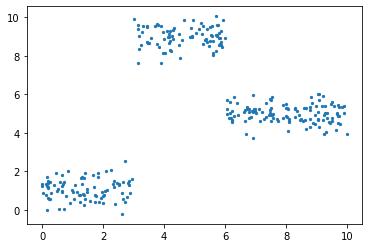

In [75]:
def f(x):
    mu, sigma = 0, 0.5
    if x < 3: return 1 + np.random.normal(mu, sigma, 1)
    elif x >= 3 and x < 6: return 9 + np.random.normal(mu, sigma, 1)
    elif x >= 6: return 5 + np.random.normal(mu, sigma, 1)
    
np.random.seed(1)
    
x = np.random.uniform(0, 10, num_points)
y = np.array( [f(i) for i in x] )

plt.scatter(x, y, s = 5)

In [82]:
def RSE(y, g): 
    return sum(np.square(y - g)) / sum(np.square(y - 1 / len(y)*sum(y)))

x_val = np.random.uniform(-2, 5, 50)
y_val = np.array( [f(i) for i in x_val] ).squeeze()

tr_preds = np.array( [predict(i) for i in df.x] )
val_preds = np.array( [predict(i) for i in x_val] )
print('Training error: {:.4f}'.format(RSE(df.y, tr_preds)))
print('Validation error: {:.4f}'.format(RSE(y_val, val_preds)))

Training error: 0.0265
Validation error: 0.0286


* Matplotlib animation code for thresholds and SSR values

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

#===================================================Create Data
def f(x):
    mu, sigma = 0, 1.5
    return -x**2 + x + 5 + np.random.normal(mu, sigma, 1)

np.random.seed(1)
    
x = np.random.uniform(-2, 5, 300)
y = np.array( [f(i) for i in x] )

p = x.argsort()
x = x[p]
y = y[p]


#===================================================Calculate Thresholds
def SSR(r, y): #send numpy array
    return np.sum( (r - y)**2 )

SSRs, thresholds = [], []
for i in range(len(x) - 1):
    threshold = x[i:i+2].mean()
    
    low = np.take(y, np.where(x < threshold))
    high = np.take(y, np.where(x > threshold))
    
    guess_low = low.mean()
    guess_high = high.mean()
    
    SSRs.append(SSR(low, guess_low) + SSR(high, guess_high))
    thresholds.append(threshold)

#===================================================Animated Plot
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True)
x_data, y_data = [], []
x_data2, y_data2 = [], []
ln, = ax1.plot([], [], 'r--')
ln2, = ax2.plot(thresholds, SSRs, 'ro', markersize = 2)
line = [ln, ln2]

def init():
    ax1.scatter(x, y, s = 3)
    ax1.title.set_text('Trying Different Thresholds')
    ax2.title.set_text('Threshold vs SSR')
    ax1.set_ylabel('y values')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('SSR')
    return line

def update(frame):
    x_data = [x[frame:frame+2].mean()] * 2
    y_data = [min(y), max(y)]
    line[0].set_data(x_data, y_data)

    x_data2.append(thresholds[frame])
    y_data2.append(SSRs[frame])
    line[1].set_data(x_data2, y_data2)
    return line

ani = FuncAnimation(fig, update, frames = 298,
                    init_func = init, blit = True)
plt.show()
#ani.save('regression_tree_thresholds_120.gif', writer='imagemagick', fps=120)